In [21]:
'''
Requirements: 

scipy=1.4.1
imageio=2.9.0
numpy=1.19.1 
pandas=1.0.5
matplotlib=3.3.1
sklearn=0.23.2
'''

import numpy as np
import scipy.stats as scs
import pandas as pd
import os
import random
import math
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel as C
from scipy.stats import norm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import imageio


In [22]:
"""
    The script for BayesOptimization
    Main functions:
    bayes_opt:
        inputs: path_to_predictions,search_space,list_of_parameters_names
        operation: given the point evaluation of the function in a csv file
        and search parameters, return the next point for function evaluation.
"""
def bayes_opt(path_to_predictions,search_space,list_of_parameters_names,maximize):
    # If the prediction file exists, run bayes optimisation else create a new one
    #print("PATH EXISTS: ",os.path.exists(path_to_predictions))
    #print(path_to_predictions)
    dict_of_means = {}
    for key in list_of_parameters_names:
        
        dict_of_means[key] = [float(search_space[key][0][1]+search_space[key][0][0])/2.0,
                              float(search_space[key][0][1]-search_space[key][0][0])/2.0]
    
    if os.path.exists(path_to_predictions):
        
        # Read the csv with predictions
        parameters_and_loss= pd.read_csv(path_to_predictions,delimiter=',')
        
        # Convert to dictionary
        parameters_and_loss_dict = parameters_and_loss.to_dict('list')
    
        # Generate function prediction from the parameters and the loss (run bayesian regression)
        loss_predicted,sigma,loss_evaluated,list_of_ranges = generate_prediction(search_space,parameters_and_loss_dict,dict_of_means,list_of_parameters_names)
        
        # Calculate expected improvement (finding the maximum of the information gain function)
        expected_improvement = calculate_expected_improvement(loss_predicted, sigma, loss_evaluated)
        
        # Find the parameter values for the maximum values of the information gain function
        next_parameter_values = find_next_parameter_values(expected_improvement,list_of_ranges,list_of_parameters_names,parameters_and_loss,maximize)
        
    else:

        parameters_and_loss = pd.DataFrame(columns = list_of_parameters_names+['loss'])
        next_parameter_values = {}
        for name in list_of_parameters_names:
            next_parameter_values[name] = search_space[name][1](search_space[name][0][0]+(search_space[name][0][1]-search_space[name][0][0])*np.random.uniform(0,1))
        
        loss_predicted = None
        sigma=None
        loss_evaluated=None
        expected_improvement=None   
        
    # Write the results into the dataframe
    list_of_next_values = []

    for item in list_of_parameters_names:
        # Add all parameters to the list, so that they can be appended to the dataframe
        # While iterating convert to the preffered datatype
        list_of_next_values.append(search_space[item][1](round(next_parameter_values[item],5)))
        next_parameter_values[item] = (search_space[item][1](round(next_parameter_values[item],5)))

    # Check that the output is not repeated (can happen as we are using white noize kernel) in this case generate point at random
    while (parameters_and_loss[list_of_parameters_names]== list_of_next_values).all(1).any():
        list_of_next_values = []
        for item in list_of_parameters_names:
            rand_value = search_space[item][1](round(random.uniform(search_space[item][0][0], search_space[item][0][1]),5))
            next_parameter_values[item] = rand_value
            list_of_next_values.append(rand_value)

    parameters_and_loss= parameters_and_loss.append(pd.DataFrame(data= [list_of_next_values],
                                                                 columns = list_of_parameters_names),
                                                    sort=False,
                                                    ignore_index=True)

    parameters_and_loss.to_csv(path_to_predictions,index=False)
    
    return next_parameter_values,loss_predicted,sigma,loss_evaluated,expected_improvement,dict_of_means


def generate_meshes(parameters_and_loss, search_space,dict_of_means, list_of_parameters_names):
    # Create a list of estimation parameters, iterate over all, skip the loss from the list
    list_of_parameters = []
    
    # Create the list of ranges for the search space (start, end, number_of_points)
    list_of_ranges = []
    list_of_shapes = []
    list_of_ranges_true =[]
    
    search_space_normalized = {}
    for key in list_of_parameters_names:
        
        search_space_normalized[key] = [(search_space[key][0][0]-dict_of_means[key][0])/dict_of_means[key][1],
                                   (search_space[key][0][1]-dict_of_means[key][0])/dict_of_means[key][1],
                                   (search_space[key][0][2])]
        #print(search_space_normalized)
        list_of_ranges_true.append (np.linspace(*search_space[key][0]))
        list_of_ranges.append(np.linspace(*search_space_normalized[key]))
        list_of_shapes.append(search_space[key][0][2])
        
    normalized_param= []
    
    for key in list_of_parameters_names:
        normalized_param=[(float(param)-dict_of_means[key][0])/dict_of_means[key][1] for param in parameters_and_loss[key]]
        
        list_of_parameters.append(np.atleast_2d(normalized_param).T)
    
    list_of_parameters_stack = np.stack(list_of_parameters,axis=1)

    # Create a meshgrid from the list of ranges for the searchspace
    meshgrid_linspace = np.meshgrid(*(list_of_ranges),indexing='ij')

    reshape_param = np.product(np.shape(meshgrid_linspace[0]))
    meshgrid_linspacer = []
    for mlinsp in meshgrid_linspace:
        meshgrid_linspacer.append(np.reshape(mlinsp,reshape_param))

    # meshgrid for GP prediction
    meshgrid_linspacer_stack = np.stack(meshgrid_linspacer,axis=1)
    
    return list_of_parameters_stack, list_of_parameters, list_of_shapes, meshgrid_linspacer_stack, list_of_ranges_true
    

def fit_gp(list_of_parameters_stack, list_of_parameters, list_of_shapes, loss_evaluated, meshgrid_linspacer_stack):
    
    # Instantiate a Gaussian Process model
    kernel = kernel =  RBF(5, (1e-2, 1e2))*C(1, (1e-2, 1e2))+ WhiteKernel(noise_level=0.2)
    
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=200)

    # Fit to data using Maximum Likelihood Estimation of the parameters
    gp.fit(np.reshape(list_of_parameters_stack,(-1,len(list_of_parameters))), loss_evaluated)

    # Make the prediction on the meshed x-axis (ask for MSE as well)
    loss_predicted, sigma = gp.predict(meshgrid_linspacer_stack, return_std=True)
    
    loss_predicted = np.reshape(loss_predicted,list_of_shapes)
    sigma = np.reshape(sigma,list_of_shapes)

    return loss_predicted, sigma 
      
    
def generate_prediction(search_space, parameters_and_loss,dict_of_means,list_of_parameters_names):

    list_of_parameters_stack, list_of_parameters, list_of_shapes, meshgrid_linspacer_stack, list_of_ranges_true = generate_meshes(parameters_and_loss,
                                                                                                                                 search_space, dict_of_means,
                                                                                                                                 list_of_parameters_names)
    loss_evaluated = parameters_and_loss['loss']
    if len(parameters_and_loss['loss'])>1:
        loss_evaluated = (parameters_and_loss['loss']-np.mean(parameters_and_loss['loss']))/(np.std(parameters_and_loss['loss'])+1e-6)
    
    loss_predicted, sigma  = fit_gp(list_of_parameters_stack, list_of_parameters, list_of_shapes, loss_evaluated, meshgrid_linspacer_stack)
    
    return loss_predicted,sigma,loss_evaluated,list_of_ranges_true


def calculate_expected_improvement(loss_predicted, sigma, loss_evaluated):
    
    # Calculate the expected improvement
    eps = 1e-6
    num =(loss_predicted-max(loss_evaluated)-eps)
    Z=num/sigma
    expected_improvement = num*scs.norm(0,1).cdf(Z)+sigma*scs.norm(0,1).pdf(Z)
    expected_improvement[sigma==0.0] = 0.0

    return expected_improvement


def find_next_parameter_values(expected_improvement,parameter_values,list_of_parameters_names,parameters_and_loss,maximize):

    if maximize:
        index = np.where(expected_improvement==np.amax(expected_improvement))
    else:
        index = np.where(expected_improvement==np.amin(expected_improvement))

    next_parameter_values = {}
    # Iterate over all parameter values and find those corresponding to maximum EI
    for idx, parameter in enumerate(list_of_parameters_names):
        
        # Since more than one value can be have max at EI,select one at random
        x = int(np.random.uniform(0,len(index[idx])))
        next_parameter_values[parameter] = parameter_values[idx][index[idx][x]]

    return next_parameter_values


In [23]:
def one_dim_function_simple(burnin):
    '''
    Maximum is attained at 12000
    '''
    f = -((burnin-12000)/10000)**2
    return f


def one_dim_function_complex(burnin):
    '''
    Maximum is attained at 12000
    '''
    f = norm.pdf((burnin-12000)/1000)+np.sin((burnin-12000)/500)/5
    return f


def two_dim_function_simple(burnin, learning_rate):
    '''
    Maximum is attained at 12000, 1.5
    '''
    f = (-((burnin-12000)/10000)**2)+(-(learning_rate-1.25)**2)
    return f


def two_dim_function_complex(burnin, learning_rate):
    '''
    Maximum is attained at 12000, 1.5
    '''
    
    x = (burnin-12000)/1000
    y = (learning_rate-1)*2-1.5
    
    f = (1-(x**2+y**3))*np.exp(-(x**2+y**2)/2)

    return f



# 1D Example

0


/usr/local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.8/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/usr/local/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


1
2
3
4
5


KeyboardInterrupt: 

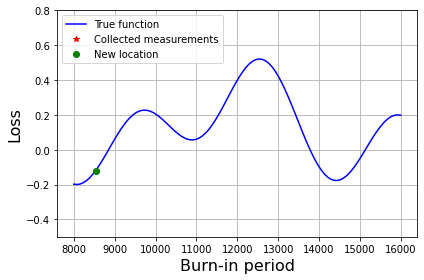

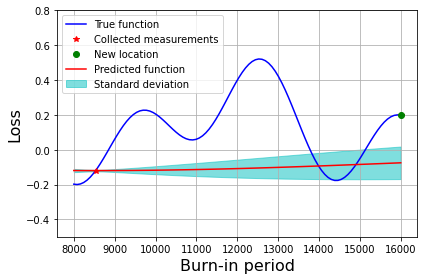

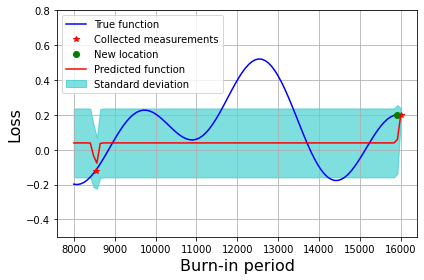

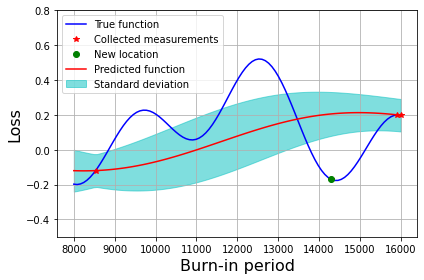

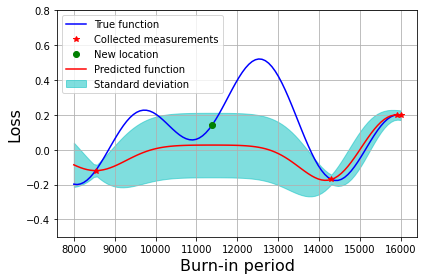

In [33]:



number_of_iterations = 15


# Dictionary:
# Key: parameter name
# Entry: tupple with (i) a list for the search space interval (start_val, end_val, num_points) and (ii) type of parameter
search_space = {'burnin_period':([8000, 16000, 100],int)}
maximize=True

list_of_parameters_names = ['burnin_period']
path_to_predictions = 'test.csv'


if not os.path.isdir('figures_1D'):
    os.mkdir('./figures_1D/')

if os.path.isfile(path_to_predictions):
    os.remove(path_to_predictions)


for ii in range(0, number_of_iterations):
    print(ii)
    
    # Fit and get the next point to sample at
    params,loss_predicted,sigma,loss_evaluated,expected_improvement,dict_of_means = bayes_opt(path_to_predictions,search_space,list_of_parameters_names,maximize)
    
    
    # Generate the predition from the true function
    res = one_dim_function_complex(params['burnin_period'])
    
    # Read the data already sampled
    data = pd.read_csv(path_to_predictions, delimiter =',')
    
    mean_loss =np.mean(data.loc[0:(len(data)-2),'loss'].values)
    std_loss =np.std(data.loc[0:(len(data)-2),'loss'].values)

    # Append the new datapoint to the dataframe and save
    data.at[len(data)-1, 'loss'] = res
    data.to_csv(path_to_predictions, index=False)
    
    
    
    # Plot and save the fit
    x = np.linspace(*search_space['burnin_period'][0])    
    plt.figure()
    plt.plot(x, one_dim_function_complex(x),'b',label="True function");
    plt.plot(data['burnin_period'].values,data['loss'].values,'*r',label="Collected measurements")
    plt.plot(data['burnin_period'].values[-1],data['loss'].values[-1],'og',label="New location")
        
    if ii>0:
        if ii>1:
            loss_predicted= loss_predicted*std_loss+mean_loss
            sigma= sigma*std_loss+mean_loss        

        plt.plot(x,loss_predicted,'r',label="Predicted function")
        plt.fill_between(x, loss_predicted - sigma,
                 loss_predicted + sigma,
                 alpha=0.5, color='c',label="Standard deviation")  
    plt.ylim([-.5, .8])
    plt.grid()
    plt.ylabel('Loss', fontsize=16)
    plt.xlabel('Burn-in period', fontsize=16)
    plt.tight_layout()
    plt.legend(loc = 'upper left')
    plt.savefig('figures_1D/'+str(ii)+'.png', bbox_inches='tight',dpi=300)
    

# Write out images to a gif
images = []
for ii in range(0,number_of_iterations):
    filename = 'figures_1D/'+str(ii)+'.png'
    image = imageio.imread(filename)
    images.append(image)
        
imageio.mimsave(('movie.gif'), images, duration = 1) # modify duration as needed

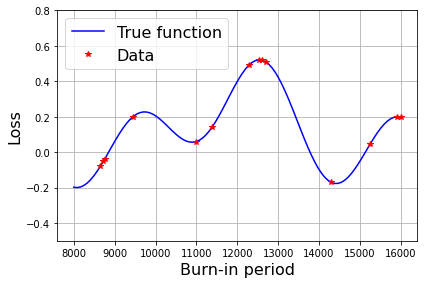

In [25]:
plt.figure()
plt.plot(x, one_dim_function_complex(x),'b',label="True function");
plt.plot(data['burnin_period'].values[:-1],data['loss'].values[:-1],'*r',label="Data")
        
plt.grid()
plt.ylabel('Loss', fontsize=16)
plt.xlabel('Burn-in period', fontsize=16)
plt.tight_layout()
plt.ylim([-.5, .8])
plt.legend(fontsize=16)

plt.savefig('./fig_1.png', bbox_inches='tight',dpi=300)

No handles with labels found to put in legend.


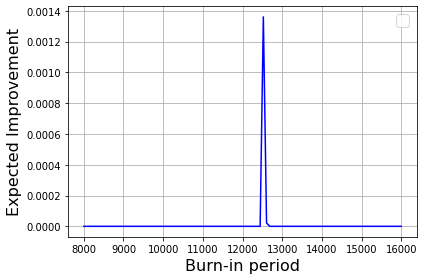

In [26]:
plt.figure()
plt.plot(x, expected_improvement,'b',label="");
#plt.plot(data['burnin_period'].values[:-1],data['loss'].values[:-1],'*r',label="Data")
        
plt.grid()
plt.ylabel('Expected Improvement', fontsize=16)
plt.xlabel('Burn-in period', fontsize=16)
plt.tight_layout()
plt.legend(fontsize=16)

plt.savefig('./fig_2.png', bbox_inches='tight',dpi=300)


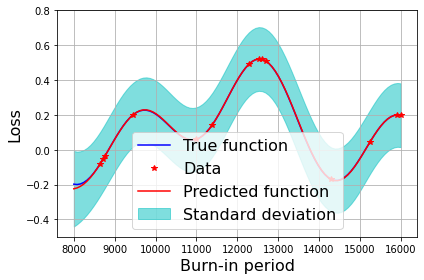

In [27]:
plt.figure()
plt.plot(x, one_dim_function_complex(x),'b',label="True function");
plt.plot(data['burnin_period'].values[:-1],data['loss'].values[:-1],'*r',label="Data")
plt.plot(x,loss_predicted,'r',label="Predicted function")
plt.fill_between(x, loss_predicted - sigma,
         loss_predicted + sigma,
         alpha=0.5, color='c',label="Standard deviation")  
plt.grid()
plt.ylim([-.5, .8])
plt.ylabel('Loss', fontsize=16)
plt.xlabel('Burn-in period', fontsize=16)
plt.tight_layout()
plt.legend(fontsize=16)

plt.savefig('./fig_3.png', bbox_inches='tight',dpi=300)

# 2D Example

0


/usr/local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.8/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/usr/local/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


<ipython-input-28-571b81a2996c>:43: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


21


KeyboardInterrupt: 

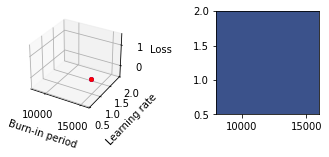

Error in callback <function flush_figures at 0x11fe630d0> (for post_execute):


KeyboardInterrupt: 

In [28]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import imageio

if os.path.isfile(path_to_predictions):
    os.remove(path_to_predictions)


number_of_iterations = 30

# Dictionary:
# Key: parameter name
# Entry: tupple with (i) a list for the search space interval (start_val, end_val, num_points) and (ii) type of parameter
search_space = {'burnin_period':([8000, 16000, 100],int),
                'learning_rate':([0.5, 2.0, 100],float)}

if not os.path.isdir('figures_1D'):
    os.mkdir('./figures_2D/')
    
maximize=True

list_of_parameters_names = ['burnin_period','learning_rate']
path_to_predictions = 'test.csv'
    
for ii in range(0, number_of_iterations):
    print(ii)
    
    # Generate the next point to sample
    params,loss_predicted,_,loss_evaluated,expected_improvement,_ = bayes_opt(path_to_predictions,search_space,list_of_parameters_names,maximize)
    
    # Measure the result at the sampled location
    res= two_dim_function_complex(params['burnin_period'],params['learning_rate'])
    data =pd.read_csv(path_to_predictions, delimiter =',')
    
    mean_loss =np.mean(data.loc[0:(len(data)-2),'loss'].values)
    std_loss =np.std(data.loc[0:(len(data)-2),'loss'].values)


    data.at[len(data)-1, 'loss'] = res    
    data.to_csv(path_to_predictions, index=False)
    
    
    
    
    # Plot the data
    fig = plt.figure()
    ax = fig.add_subplot(1,2,1, projection='3d')
    # Make data.
    burnin_period =  np.linspace(*search_space['burnin_period'][0])
    learning_rate =  np.linspace(*search_space['learning_rate'][0]) 
    X, Y = np.meshgrid(burnin_period, learning_rate,indexing='ij')

    Z = two_dim_function_complex(X, Y)

    # Customize the z axis.
    ax.set_zlim(-.5, 1.5)
    ax.set_ylim(search_space['learning_rate'][0][0], search_space['learning_rate'][0][1])
    ax.set_xlim(search_space['burnin_period'][0][0], search_space['burnin_period'][0][1])
    ax.set_xlabel('Burn-in period')
    ax.set_ylabel('Learning rate')
    ax.set_zlabel('Loss')

    ax.scatter(data['burnin_period'].values, data['learning_rate'].values, data['loss'].values, color='b', linewidth=0.5);
    ax.scatter(data['burnin_period'].values[-1], data['learning_rate'].values[-1], data['loss'].values[-1], color='r', linewidth=0.5);

        
    if ii>0:
        if ii>1:
            loss_predicted= loss_predicted*(std_loss+1e-6)+mean_loss        
        
        surf_2 = ax.plot_surface(X,Y, loss_predicted, cmap=cm.coolwarm, linewidth=0, antialiased=False)
        
    
    ax = fig.add_subplot(1,2,2)
    if ii>0:
        #fig = plt.figure()
        
        ax.contour(X,Y,loss_predicted)
        ax.contourf(X,Y,loss_predicted, cmap='viridis')
        ax.plot(data['burnin_period'].values, data['learning_rate'].values, 'ko')
        
        ax.plot(data['burnin_period'].values[-1], data['learning_rate'].values[-1], 'ro')
        ax.set_xlabel('Burn-in period')
        ax.set_ylabel('Learning rate')
    else:
        ax.contourf(X,Y,np.zeros((np.shape(X))), cmap='viridis')
        
    ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
    fig.tight_layout(pad=6.0)
    fig.savefig('figures_2D/'+str(ii)+'_2D_contour.png', bbox_inches='tight',dpi=300)


images = []
for ii in range(1,number_of_iterations):
    filename = 'figures_2D/'+str(ii)+'_2D_contour.png'
    image = imageio.imread(filename)
    images.append(image)
        
imageio.mimsave(('fit_2D.gif'), images, duration = .5) # modify duration as needed


